### Imports

In [1]:
# imports

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

In [2]:
# getting rid of some warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in combined dataframe
df = pd.read_csv('../data/combined.csv', index_col = 0)
df

,subreddit,title,created_utc,is_video,num_comments
0,cycling,Women cyclists. What do you think when the men...,1682463592,False,0
1,cycling,Inaccurate Shimano Power Meter,1682463280,False,0
2,cycling,Never been on a road bike before and WOW,1682459187,False,0
3,cycling,2012 Fuji Supreme LTD Team for 600? Good deal?,1682458960,False,0
4,cycling,bike making weird sound when biking in 1st,1682456616,False,0
...,...,...,...,...,...
994,running,Grandma's Marathon 2023,1678899332,False,1
995,running,"I’ve just started running, how many times a we...",1678897479,False,1
996,running,Running Instagram Profiles,1678895309,False,1
997,running,What are the latest justifications for why sup...,1678894757,False,1


## Pre-Processing

In [4]:
# create lemmatizer function

def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in text.split()]

In [5]:
# instantiate lemmatizer
wnet = WordNetLemmatizer()

# create a stop_words list from lemmatizer
lem_stopwords = [wnet.lemmatize(w) for w in stopwords.words('english')]

In [6]:
# model evaluation function 

def model_evaluation(y_test, preds):
    
    # setting the positive value to be equal to 'cycling'

    recall = recall_score(y_test, preds, pos_label='cycling')
    precision = precision_score(y_test, preds, pos_label='cycling')
    f1 = f1_score(y_test, preds, pos_label= 'cycling')
    accuracy = accuracy_score(y_test, preds)

    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1: {f1}')
    print(f'accuracy: {accuracy}')

In [7]:
X = df['title']
y = df['subreddit']

#### Baseline Accuracy

In [8]:
y.value_counts(normalize = True)

cycling    0.5
running    0.5
Name: subreddit, dtype: float64

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Modeling

## CountVectorizer and Logistic Regression

In [10]:
pipe_lr = Pipeline([
    ('cv', CountVectorizer(stop_words = lem_stopwords, 
                            tokenizer = my_lemmatizer)),
    ('lr', LogisticRegression())
])

In [11]:
pipe_params = {
    'cv__max_features': [2000, 3000, 4000],
    'cv__min_df': [2, 4],
    'cv__max_df': [1.0, 0.8, 0.5],
}

In [12]:
gs_lr = GridSearchCV(pipe_lr,
                  param_grid=pipe_params,
                  cv = 5,
                  n_jobs = -1)

In [13]:
# check crossvalscore
cross_val_score(pipe_lr, X_train, y_train, cv=3, n_jobs = -1).mean()

0.8703875176043288

In [14]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function my_lemmatizer at 0x000002440624B7F0>)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [1.0, 0.8, 0.5],
                         'cv__max_features': [2000, 3000, 4000],
                         'cv__min_df': [2, 4]})

In [15]:
gs_lr.best_params_

{'cv__max_df': 1.0, 'cv__max_features': 3000, 'cv__min_df': 2}

In [16]:
gs_lr.best_score_

0.868830058089235

In [17]:
lr_preds = gs_lr.predict(X_test)

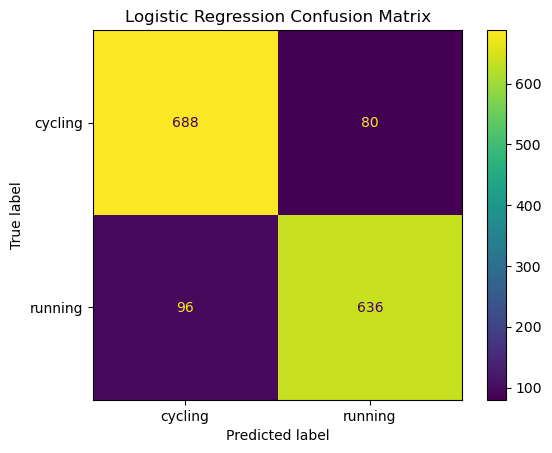

In [53]:
ConfusionMatrixDisplay.from_estimator(gs_lr, X_test, y_test);
plt.title('Logistic Regression Confusion Matrix');
plt.savefig('../imgs/lr_cm.png');

In [19]:
model_evaluation(y_test, lr_preds)

recall: 0.8958333333333334
precision: 0.8775510204081632
f1: 0.8865979381443299
accuracy: 0.8826666666666667


- Overall, this model does pretty well. It has an accuracy of 88.2% and is relatively balanced.

## CountVectorizer with a Random Forest

In [20]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [21]:
pipe_params = {
    'cv__max_features': [2000, 3000, 4000],
    'cv__min_df': [2, 4],
    'cv__max_df': [1.0, 0.8, 0.5],
    'rf__max_depth': [40],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__n_jobs': [-1]
}

In [22]:
gs_rf = GridSearchCV(pipe_rf,
                  param_grid=pipe_params,
                  cv = 5, n_jobs = -1)

In [23]:
cross_val_score(pipe_rf, X_train, y_train, cv=3, n_jobs = -1).mean()

0.8677193684678675

In [24]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [1.0, 0.8, 0.5],
                         'cv__max_features': [2000, 3000, 4000],
                         'cv__min_df': [2, 4], 'rf__max_depth': [40],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5], 'rf__n_jobs': [-1]})

In [25]:
gs_rf.best_params_

{'cv__max_df': 1.0,
 'cv__max_features': 4000,
 'cv__min_df': 2,
 'rf__max_depth': 40,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_jobs': -1}

In [26]:
gs_rf.best_score_

0.8590465949820789

In [27]:
rf_preds = gs_rf.predict(X_test)

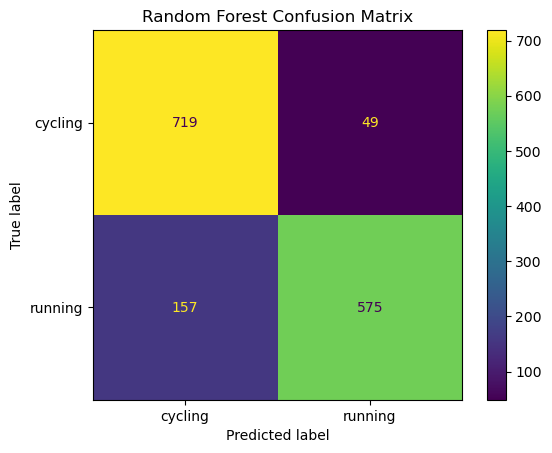

In [54]:
ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test);
plt.title('Random Forest Confusion Matrix');
plt.savefig('../imgs/rf_cm.png');

In [29]:
model_evaluation(y_test, rf_preds)

recall: 0.9361979166666666
precision: 0.8207762557077626
f1: 0.8746958637469586
accuracy: 0.8626666666666667


- Interestingly, this model did quite well for recall with 93.6% score. This would be good for checking if a post is correctly from /r/cycling. 

## Bagging with CountVectorizer

In [30]:
pipe_bag = Pipeline([
    ('cv', CountVectorizer()),
    ('bag', BaggingClassifier())
])

In [31]:
pipe_params = {
    'cv__max_features': [2000, 3000, 4000],
    'cv__min_df': [2, 4],
    'cv__max_df': [1.0, 0.8, 0.5],
    'bag__n_estimators': [5, 10, 15],
    'bag__max_features': [0.5, 0.8, 1.0]
}

In [32]:
gs_bag = GridSearchCV(pipe_bag,
                  param_grid=pipe_params,
                  cv = 5,
                  n_jobs = -1)

In [33]:
cross_val_score(pipe_bag, X_train, y_train, cv=3).mean()

0.8521575865391743

In [34]:
gs_bag.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('bag', BaggingClassifier())]),
             n_jobs=-1,
             param_grid={'bag__max_features': [0.5, 0.8, 1.0],
                         'bag__n_estimators': [5, 10, 15],
                         'cv__max_df': [1.0, 0.8, 0.5],
                         'cv__max_features': [2000, 3000, 4000],
                         'cv__min_df': [2, 4]})

In [35]:
gs_bag.best_params_

{'bag__max_features': 0.5,
 'bag__n_estimators': 15,
 'cv__max_df': 0.8,
 'cv__max_features': 4000,
 'cv__min_df': 2}

In [36]:
gs_bag.best_score_

0.8750577184526016

In [37]:
bag_preds = gs_bag.predict(X_test)

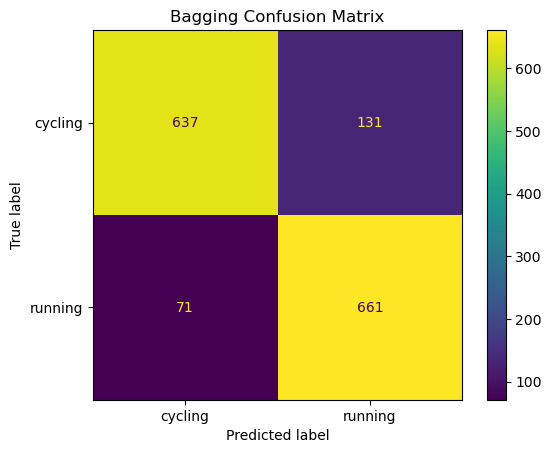

In [55]:
ConfusionMatrixDisplay.from_estimator(gs_bag, X_test, y_test);
plt.title('Bagging Confusion Matrix');
plt.savefig('../imgs/bag_cm.png');

In [39]:
model_evaluation(y_test, bag_preds)

recall: 0.8294270833333334
precision: 0.8997175141242938
f1: 0.8631436314363143
accuracy: 0.8653333333333333


- Not amazing performance from this model, but it isn't too far behind the other two models. It does have slightly higher precision, which may be good if we are looking for a low variance. However, it does suggest this model is underfit.

## AdaBoost with CountVectorizer

In [40]:
pipe_ada = Pipeline([
    ('cv', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=RandomForestClassifier()))
])

In [41]:
pipe_params = {
    'cv__max_features': [2000, 3000, 4000],
    'cv__min_df': [2, 4],
    'cv__max_df': [1.0, 0.8, 0.5],
    'ada__n_estimators': [50],
    'ada__learning_rate': [0.9]
}

In [42]:
gs_ada = GridSearchCV(pipe_ada,
                  param_grid=pipe_params,
                  cv = 5,
                  n_jobs = -1)

In [43]:
cross_val_score(pipe_ada, X_train, y_train, cv=3, n_jobs = -1).mean()

0.8572728485657105

In [44]:
gs_ada.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=RandomForestClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.9], 'ada__n_estimators': [50],
                         'cv__max_df': [1.0, 0.8, 0.5],
                         'cv__max_features': [2000, 3000, 4000],
                         'cv__min_df': [2, 4]})

In [45]:
gs_ada.best_params_

{'ada__learning_rate': 0.9,
 'ada__n_estimators': 50,
 'cv__max_df': 1.0,
 'cv__max_features': 3000,
 'cv__min_df': 2}

In [46]:
gs_ada.best_score_

0.8370384377703621

In [50]:
ada_preds = gs_bag.predict(X_test)

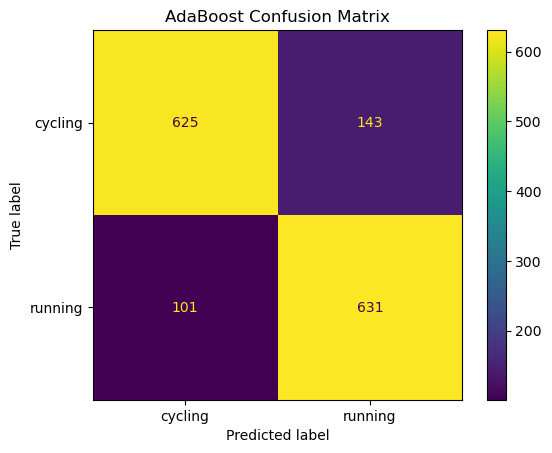

In [56]:
ConfusionMatrixDisplay.from_estimator(gs_ada, X_test, y_test);
plt.title('AdaBoost Confusion Matrix');
plt.savefig('../imgs/ada_cm.png');

In [52]:
model_evaluation(y_test, ada_preds)

recall: 0.8294270833333334
precision: 0.8997175141242938
f1: 0.8631436314363143
accuracy: 0.8653333333333333


- Wow! It's interesting to see that the ensemble methods Bagging and AdaBoost had basically the exact same rounded metric scores. I think it's because of the lack of diversity in my dataset as well my hyperparameters.

---
&nbsp; 

<center><h3>Model Performance Summary</h3></center>

|**Model Name**|Recall|Precision|F1|Accuracy|
|---|---|---|---|---|
|Logistic Regression|0.8958|0.8775|0.8865|0.8827|
|Random Forest|0.9362|0.8207|0.8747|0.8653|
|Bagging|0.8294|0.8997|0.8631|0.8653|
|AdaBoost|0.8294|0.8997|0.8631|0.8653|

&nbsp; 

## Conclusion and Recommendations
In this project, the highest performing classification model of the four chosen was **Logistic Regression** with an accuracy score of **88.2%**. Overall, this score is good, but not as high as I would have hoped for. The other three models trail in performance, but not too far. From our initial exploratory analysis, we found that /r/cycling has posts that tended to focus more on equipment and upgrades. /r/Running, on the other hand, focused more on individual performance. The ensemble models had the exact same rounded metric scores, which highlight that our dataset does not have enough variety in features or hyperparameters. In the future, I hope to use a more varied dataset, with greater feature engineering and distinct hyperparameters to help combat this. Additionally, adding more specific stopwords would be helpful in removing unnecessary noise from the dataset. While I did not use it, sentimental analysis could help in separating posts by emotion. Future models also should find a way to incorporate the subreddit body text and comments, despite its current implementation that seemingly prevents so.